### General function for cleaning corpus 

In [2]:
import pandas as pd
import spacy
import string
from langdetect import detect
import re 
import nltk
from nltk.corpus import stopwords
from gensim.models import Phrases
from gensim.corpora import Dictionary
from gensim.models import LdaModel

nlp = spacy.load("en_core_web_lg")

contractions_dict = { "ain’t": "are not", "’s":" is", "aren’t": "are not", "can’t": "cannot", 
                     "can’t’ve": "cannot have", "’cause": "because", "could’ve": "could have", 
                     "couldn’t": "could not", "couldn’t've": "could not have", "didn’t": "did not", 
                     "doesn’t": "does not", "don’t": "do not", "hadn’t": "had not", 
                     "hadn’t’ve": "had not have", "hasn’t": "has not", "haven’t": "have not",
                     "he’d": "he would", "he’d’ve": "he would have", "he’ll": "he will", 
                     "he’ll’ve": "he will have", "how’d": "how did", "how’d’y": "how do you", 
                     "how’ll": "how will", "i’d": "i would", "i’d’ve": "i would have", "i’ll": "i will",
                     "i’ll’ve": "i will have", "i’m": "i am", "i’ve": "i have", "isn’t": "is not",
                     "it’d": "it would", "it’d’ve": "it would have", "it’ll": "it will", 
                     "it’ll’ve": "it will have", "let’s": "let us", "ma’am": "madam", "mayn’t": "may not",
                     "might’ve": "might have", "mightn’t": "might not", "mightn’t’ve": "might not have",
                     "must’ve": "must have", "mustn’t": "must not", "mustn’t’ve": "must not have",
                     "needn’t": "need not", "needn’t’ve": "need not have", "o’clock": "of the clock",
                     "oughtn’t": "ought not", "oughtn’t’ve": "ought not have", "shan’t": "shall not",
                     "sha’n’t": "shall not", "shan’t’ve": "shall not have", "she’d": "she would",
                     "she’d’ve": "she would have", "she’ll": "she will", "she’ll’ve": "she will have", 
                     "should’ve": "should have", "shouldn’t": "should not", "shouldn’t’ve": "should not have",
                     "so’ve": "so have", "that’d": "that would", "that’d’ve": "that would have",
                     "there’d": "there would", "there’d’ve": "there would have", "they’d": "they would",
                     "they’d’ve": "they would have","they’ll": "they will", "they’ll’ve": "they will have",
                     "they’re": "they are", "they’ve": "they have", "to’ve": "to have", "wasn’t": "was not",
                     "we’d": "we would", "we’d’ve": "we would have", "we’ll": "we will", "we’ll’ve": "we will have",
                     "we’re": "we are", "we’ve": "we have", "weren’t": "were not","what’ll": "what will",
                     "what’ll've": "what will have", "what’re": "what are", "what’ve": "what have",
                     "when’ve": "when have", "where’d": "where did", "where’ve": "where have", 
                     "who’ll": "who will", "who’ll’ve": "who will have", "who’ve": "who have",
                     "why’ve": "why have", "will’ve": "will have", "won’t": "will not",
                     "won’t’ve": "will not have", "would’ve": "would have", "wouldn’t": "would not",
                     "wouldn’t’ve": "would not have", "y’all": "you all", "y’all’d": "you all would",
                     "y’all’d'’ve": "you all would have", "y’all’re": "you all are",
                     "y’all’ve": "you all have", "you’d": "you would", "you’d’ve": "you would have",
                     "you’ll": "you will", "you’ll’ve": "you will have", "you’re": "you are",
                     "you’ve": "you have"}


def expand_contractions(s, contractions_dict=contractions_dict):
  contractions_re = re.compile('(%s)'%'|'.join(contractions_dict.keys()))
  def replace(match):
    return contractions_dict[match.group(0)]
  return contractions_re.sub(replace, s)


def clean_hashtag_url(post):
    """
    remove all hastags and website links from a string
    """    

    return " ".join(word for word in post.split(' ') if ("#" not in word and "http" not in word))

def punct_space(token):
    """
    helper function to eliminate tokens
    that are pure punctuation or whitespace
    """

    return token.is_punct or token.is_space

def rm_pattern(post):
    """
    function returning a string without "...see more" and website links from the post. 
    This function uses "re.sub" to remove a specific pattern"""

    post = re.sub("…see more",'', post) # replace pattern by an empty string
    post = re.sub('http','',post)
    return post

def preprocess(post):
    
    clean_text = post.translate(str.maketrans("", "", string.punctuation))
    clean_text = clean_text.replace("\n", " ")
    clean_text = clean_text.replace("\u200d", "")
    clean_text = clean_text.replace("\u200b", "")
    clean_text = clean_text.replace("▪", "")
    clean_text = clean_text.replace("’", "")
    clean_text = clean_text.replace("”", "")
    clean_text = clean_text.lower()
    stop_words = set(stopwords.words('english')) - {'we', 'i', 'you', 'our', 'himself', 'herself', 'him', 'hers', 'his', 'her', 'ourselves', 'themselves', 'ours'}
    clean_text = " ".join([word for word in clean_text.split() if word not in stop_words])
    clean_text = " ".join(clean_text.split())
    
    return clean_text

def rules(token):
    """
    conditions to select a specific token for the corpus cleaning
    used with all() function : return True if all True.
    Conditions are : no pure puncuation - no pure whitespace - not a stopword 
    - not a #word
    """

    return [not punct_space(token)] 

def corpus_cleaning(posts):
    """
    generator function using spaCy to parse posts,
    remove "...see more" pattern, website links, lemmatize the text, lowercase words, and apply all the conditions we have set in rules.
    What this function returns is a generator (a "list") of individual tokens contained in lists. 
    """
    
    for post in nlp.pipe(posts.apply(rm_pattern)):
        yield ' '.join([token.lemma_ for token in post if all(rules(token))])

def main_token(json_name,column_name_corpus):

    nltk.download('stopwords')
    df = pd.read_json(json_name)

    df['language'] = df[column_name_corpus].apply(detect)
    df=df[df['language']!= 'es'].drop('language', axis=1)

    corpus=df[column_name_corpus]

    corpus = corpus.apply(expand_contractions)

    corpus = corpus.apply(clean_hashtag_url)
    corpus = corpus.apply(preprocess)

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)
    all_posts = []
    for streamed_post in streamed_posts:
        post = ' '.join(streamed_post)
        all_posts.append(post)

    # Process after cleaning

    df['descripcion_clean'] = all_posts

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)
    bigram_model = Phrases(streamed_posts,min_count=5,threshold=10)

    bigram_posts = []

    preprocessed_posts = corpus_cleaning(corpus)
    streamed_posts = (post.split(' ') for post in preprocessed_posts)

    for streamed_post in streamed_posts:
        bigram_post = ' '.join(bigram_model[streamed_post])
        bigram_posts.append(bigram_post)

    clean_corpus=bigram_posts

    return clean_corpus

### Clean corpus posts of each company

In [3]:
# Clean corpus posts Asesoftware

asesoftware_posts=main_token("posts.json","descripcion")
print(asesoftware_posts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['we lead trend 2022️artificial intelligence ️data analytics ️rpawhich one you implement business', 'almost 2022 we_want share ai lead trend future year', 'we demonstrate method aid mathematician discover new that_s simply amazing thing evolve field', 'limit rpa imagination programmer 🤖 ️can you tell we rpa box application juan carlos castaño valencia diana cristhina pérez pérez fabian esteban peña castillo', 'introduce indoor garden control app ai enjoy fresh vegetable every day let you grow 64 plant simultaneously green ai mashable', 'five way al contribute wildlifeconservation 1 vast datum collection 📊 2 study protect specie 🐨 3 track wildlife pattern 📈 4 prediction endanger specie 🐼 5 classify animal specie', 'participant plan_semilla apprenticeship talk experience last month today we_want thank_you congratulate you effort welcome team 👏 🏻 👏 🏻 👏 🏻thomas clarke juan francisco rodríguez hernández favio juan_sebastián casas_castillo leidy romero', 'today we welcome new member our team

In [4]:
# Clean corpus posts Globant

globant_posts=main_token("globant_linkedin.json","content")
print(globant_posts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['⭐ ️ join_we exciting webinar power culture technology achieve success 👉 learn our expert 🟢 guibert_englebienne globant cofounder president globant x president globant latam 🟢 adriana sclar cultural hacking_studio partner globant don´t miss opportunity revolutionize you approach change culture workplace 🚀 book spot today 18 april 🕒 12pm arg 17pm cet 20pm', 'last decade we research develop technology around ai ai enter accelerated phase surprise everyone new way computer interact human take_look our ai manifesto statement ethical complexity', 'exciting news we thrill announce we_ve select market leader among digital engineering service provider late hfs research horizon report recognition lead global analyst firm testament our commitment deliver innovative solution our_client report highlight our studio modelbase offering strength include our focus provide highquality solution talent management differentiation technology innovationthank glober support our_client partner trust we remain

In [5]:
# Clean corpus posts Accenture

accenture_posts=main_token("accenture_linkedin.json","content")
print(accenture_posts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['ready enter virtual world discover new frontier create strong bond brand business profit check our full report', 'ever_wonder technological advancement today life business tomorrow explore next frontier tech innovation', 'disruptionproof workflow fiction it reality industrial business tool need increase efficiency transparency already learn', 'truly new possibility lie ahead we arrive exciting frontier technology innovation explore four trend_shape future discover', '🗓 ️ save date key technology trend emerge our physical virtual world blend one share reality join_we special event we explore trend_shape business technology next_decade rsvp today', 'next wave business transformation merge our digital physical world create radically new opportunity business leader available we share 4 digital trend_shape future our new share reality 🔮', 'invest people reduce our impact planet we measure value across area our business explore drive change make', 'reinvention long onetime execution contin

### NLP function

In [155]:
import nltk
nltk.download('punkt')
from gensim.models import Word2Vec

def NLP_model(corpus, name_model):
    corpus_tok = [nltk.word_tokenize(sent) for sent in corpus]

    # Define los parámetros de tu modelo personalizado
    vector_size = 20
    window_size = 5

    # Construye el vocabulario de tu modelo utilizando las palabras del corpus tokenizado
    model = Word2Vec(corpus_tok, vector_size=vector_size, window=window_size, min_count=1, workers=4)

    # Entrena el modelo Word2Vec con el corpus tokenizado
    model.train(corpus_tok, total_examples=len(corpus_tok), epochs=500)

    # Guarda el modelo entrenado para su uso posterior
    model.save(name_model)

    return model


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\wdmoreno\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [156]:
# Models

ASW_model=NLP_model(asesoftware_posts,"biasASW_word2vec.model")
Globant_model=NLP_model(globant_posts,"biasGlobant_word2vec.model")
Accenture_model=NLP_model(accenture_posts,"biasAccenture_word2vec.model")

### Comparition of model and BIAS

In [176]:
# Man analysis
Word_to_analize="man"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('goalsand', 0.8920474052429199), ('laboratory', 0.8142807483673096), ('🏼️to', 0.7840545177459717), ('1903', 0.77959144115448), ('coming', 0.7517845034599304)]
Globant:  [('ago', 0.9889087677001953), ('resurgence', 0.901428759098053), ('couple', 0.8989702463150024), ('responsible', 0.8396062850952148), ('home', 0.7999252676963806)]
Accenture:  [('family', 0.8053879737854004), ('make_difference', 0.7527860999107361), ('community', 0.722317099571228), ('premier', 0.6550402045249939), ('1200', 0.65053790807724)]


In [157]:
# Man analysis
Word_to_analize="👨"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('telemedicine', 0.8468592166900635), ('⚖', 0.8133248090744019), ('️taken', 0.7978372573852539), ('🦱', 0.772733211517334), ('️marvin', 0.7553561329841614)]
Globant:  [('⚕', 0.835380494594574), ('️learn', 0.729133129119873), ('🦾', 0.670179009437561), ('monday', 0.6519438028335571), ('🏾', 0.6432270407676697)]
Accenture:  [('🗨', 0.9088802337646484), ('🏽🦯🧍🏼', 0.9009950160980225), ('👩', 0.8785505294799805), ('🏻🦼🧍🏽', 0.875285804271698), ('🦱', 0.8441388010978699)]


In [177]:
# Man analysis
Word_to_analize="woman"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('sweep', 0.728387176990509), ('guide', 0.6903038024902344), ('🏼️to', 0.6427993178367615), ('️feminism', 0.6207708716392517), ('celebration', 0.6163848638534546)]
Globant:  [('global_community', 0.7866573929786682), ('inspire', 0.7507503032684326), ('career', 0.7280642986297607), ('award', 0.7230604887008667), ('nominate', 0.7070133686065674)]
Accenture:  [('😱', 0.7193429470062256), ('🤔', 0.7065935730934143), ('shontell', 0.7027441263198853), ('5300000', 0.6712548732757568), ('conversation', 0.6670917272567749)]


In [158]:
# Woman analysis
Word_to_analize="👩"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('🦱', 0.6847290396690369), ('️share', 0.6659395694732666), ('👨', 0.6579545736312866), ('finland', 0.6483443975448608), ('ve', 0.6453558802604675)]
Globant:  [('mathematic', 0.7909209728240967), ('💻', 0.6952285766601562), ('collaborative', 0.6706119179725647), ('environmentsthis', 0.6629440784454346), ('🏽', 0.6555370688438416)]
Accenture:  [('🦱', 0.9325497150421143), ('👨', 0.8785504698753357), ('🏽🦯🧍🏼', 0.8714728951454163), ('🏾', 0.8665698170661926), ('🏻🦼🧍🏽', 0.8449329733848572)]


In [159]:
# Woman analysis
Word_to_analize="technology"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('knowledge', 0.7570128440856934), ('ai', 0.7490699887275696), ('computing', 0.7254531383514404), ('crack', 0.6896082162857056), ('new', 0.6893728375434875)]
Globant:  [('business', 0.8023273944854736), ('learn', 0.7885039448738098), ('journey', 0.7878891229629517), ('build', 0.7830938696861267), ('reinvent', 0.7757501602172852)]
Accenture:  [('business', 0.8401443362236023), ('learn', 0.8102705478668213), ('find', 0.7686336636543274), ('organization', 0.7524633407592773), ('datum', 0.7239726185798645)]


In [179]:
# Man analysis
Word_to_analize="ai"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('technology', 0.7490700483322144), ('we', 0.7487031817436218), ('design', 0.7319573760032654), ('work', 0.6981328129768372), ('build', 0.6961966156959534)]
Globant:  [('reinventiondiscover', 0.7289672493934631), ('cuttingedge', 0.6991399526596069), ('datum', 0.6624425649642944), ('embed', 0.6415977478027344), ('backbone', 0.6348121762275696)]
Accenture:  [('fed', 0.6565995812416077), ('area', 0.631525993347168), ('far', 0.6302372813224792), ('audience', 0.6275002360343933), ('dig', 0.6087941527366638)]


In [160]:
# Woman analysis
Word_to_analize="💡"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('form', 0.8038603067398071), ('outstanding', 0.7832512855529785), ('application', 0.7728258967399597), ('aidatacentred', 0.7590773701667786), ('concept', 0.7479620575904846)]
Globant:  [('relive', 0.7510320544242859), ('revisit', 0.7441245317459106), ('multipart', 0.6702830195426941), ('documentary', 0.6420345306396484), ('👓', 0.6225743889808655)]
Accenture:  [('exposure', 0.9352597594261169), ('retention', 0.8785403370857239), ('credibility', 0.7299210429191589), ('store', 0.7021828293800354), ('heroeslearn', 0.689737856388092)]


In [161]:
# Woman analysis
Word_to_analize="👏"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('ps', 0.8057220578193665), ('ocampo', 0.7619762420654297), ('passion', 0.749285876750946), ('yepes', 0.7070441246032715), ('goalsand', 0.6662052869796753)]
Globant:  [('locate', 0.7744585275650024), ('👏_👏', 0.7704657912254333), ('site', 0.7477392554283142), ('we_want', 0.7183728814125061), ('city', 0.7149662375450134)]
Accenture:  [('🦾', 0.867545485496521), ('permanently', 0.7639598846435547), ('underground', 0.7061139345169067), ('climework', 0.6814483404159546), ('dog', 0.6800752878189087)]


In [162]:
# Woman analysis
Word_to_analize="📚"

similaresASW = ASW_model.wv.most_similar(Word_to_analize,topn=5)
similaresGlobant = Globant_model.wv.most_similar(Word_to_analize,topn=5)
similaresAccenture = Accenture_model.wv.most_similar(Word_to_analize,topn=5)

print("ASW: ", similaresASW)
print("Globant: ",similaresGlobant)
print("Accenture: ",similaresAccenture)

ASW:  [('scratch', 0.8160738348960876), ('environmental', 0.7267698645591736), ('tea', 0.712929368019104), ('collect', 0.6942961812019348), ('prefer', 0.6871665120124817)]
Globant:  [('turner', 0.7130439877510071), ('page', 0.7066900730133057), ('fashioned', 0.6449099779129028), ('especially', 0.6429582834243774), ('fill', 0.6327333450317383)]
Accenture:  [('little', 0.9115121364593506), ('holiday', 0.7225311994552612), ('modernize', 0.6892540454864502), ('synche', 0.675854504108429), ('siloed', 0.6693801283836365)]


In [163]:
# Get the most common words for each model

ASW_common = ASW_model.wv.index_to_key[:100]
Globant_common = Globant_model.wv.index_to_key[:100]
Accenture_common = Accenture_model.wv.index_to_key[:100]

# Find the common words across all 3 models
common_words = set(ASW_common) & set(Globant_common) & set(Accenture_common)

# Print the common words for each model and the common words across all 3 models
print("ASW common words:", ASW_common)
print("Globant common words:", Globant_common)
print("Accenture common words:", Accenture_common)
print("Common words across all 3 models:", common_words)


ASW common words: ['our', 'we', 'ai', 'you', 'equinox', 'work', 'use', 'learn', 'thank_you', 'design', 'technology', 'human', 'year', 'datum', 'create', 'new', 'team', 'start', 'make', 'you_want', 'quantum', '️', 'know', 'business', 'machine', 'help', 'day', 'we_want', 'article', 'write', 'one', 'robot', 'like', 'model', 'experience', 'love', 'solution', 'understand', 'quantum_computing', 'today', 'could', 'good', 'process', 'lab', 'his', 'artificial_intelligence', 'rpa', 'talk', 'course', 'apply', 'time', 'company', 'need', 'people', 'well', 'you_think', 'first', 'asesoftware', 'user', '🖤', 'information', 'way', 'carla_acosta', 'improve', 'industry', '💪', 'data', 'job', 'I', 'video', 'week', 'enjoy', 'get', 'two', 'happy', 'check', 'class', 'let', 'come', 'designer', 'share', 'different', 'take', 'build', 'world', 'our_last', 'think', 'application', 'iván_caballero', 'contact_we', 'change', 'project', 'daily', 'knowledge', 'holistic_design', 'together', 'three', '👏', 'fact', 'challeng

In [164]:
from collections import defaultdict
# Get the most common words for each model

ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Find the common words across all 3 models
common_words = set(ASW_common) & set(Globant_common) & set(Accenture_common)

# Create a dictionary of word frequencies
freq_dict = defaultdict(int)
for word in common_words:
    freq_dict[word] += 1

# Sort the dictionary by frequency and create a list of the top 100 words
sorted_words = sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)
top_words = [w[0] for w in sorted_words]

# Print the top 100 common words
print("Top common words:", top_words)

Top common words: ['prestigious', 'sebastian', 'competitiveness', 'youtube', 'quality', 'must', 'four', 'never', 's', 'session', 'believe', 'natural', 'equity', 'grow', 'seek', 'toward', 'data', 'result', 'ever', 'significant', 'us', 'register', 'want', 'model', 'three', 'background', 'celebrate', 'organization', 'page', 'fun', 'corner', 'behavior', 'answer', 'interview', '19', 'try', '🗺', 'grateful', 'society', 'rapidly', 'fact', 'healthcare', 'responsibility', 'daniel', 'part', 'even', 'sometimes', 'productivity', 'yet', 'could', 'banking', 'without', '2023', 'honor', 'hand', 'follow', 'framework', 'imagine', 'progress', 'fight', 'topic', '2030', 'since', 'operating', 'stay', 'we', 'health', 'discussion', 'leverage', 'establish', 'cycle', 'solve', 'represent', 'pandemic', 'access', 'that', 'app', 'recommendation', 'pioneer', 'first', 'field', 'adapt', 'thousand', 'perspective', 'amazing', 'seven', 'do', 'also', 'book', 'implementation', 'addition', 'recent', 'explain', 'man', 'though

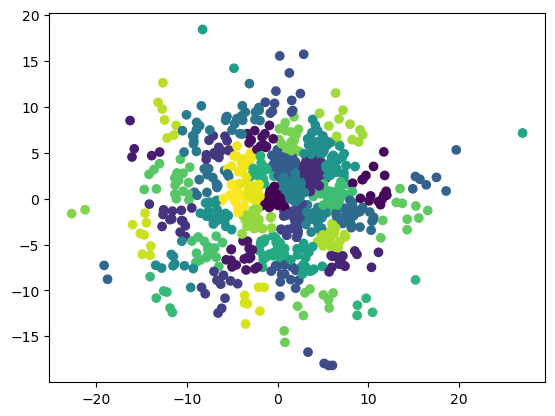

In [165]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Get the word vectors for the common words across all 3 models
common_word_vectors = []
for word in top_words:
    common_word_vectors.append(
        ASW_model.wv.get_vector(word) + 
        Globant_model.wv.get_vector(word) + 
        Accenture_model.wv.get_vector(word)
    )
    

# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=2)
common_word_vectors_pca = pca.fit_transform(common_word_vectors)

# aplicar k-means
kmeans = KMeans(n_clusters=50, random_state=0)
kmeans.fit(common_word_vectors_pca)

# graficar los resultados de k-means
plt.scatter(common_word_vectors_pca[:, 0], common_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Print the most common clusters
cluster_counts = defaultdict(int)
for i in range(len(top_words)):
    cluster_counts[kmeans.labels_[i]] += 1


In [166]:
words_in_clusters = defaultdict(list)
for i, word in enumerate(top_words):
    words_in_clusters[kmeans.labels_[i]].append(word)
    
most_common_clusters = sorted(words_in_clusters.items(), key=lambda x: len(x[1]), reverse=True)

for cluster, words in most_common_clusters:
    print(f"Cluster {cluster}: {words}")


Cluster 21: ['four', '19', 'sometimes', 'imagine', 'topic', 'operating', 'recommendation', 'adapt', 'experiment', 'standard', 'importance', 'analyze', '🚀', 'foundation', 'interest', 'situation', 'congrat', 'common', 'spend', 'already', 'present', 'option', 'visit', 'roadmap', 'wait', 'replace', 'recognition', '10', 'phenomenon', 'cover', 'cognitive', 'individual', 'account', 'commerce', 'basic', 'purchase', 'evolution', 'london', 'contribute', 'task', 'contact', 'magazine', 'technique']
Cluster 6: ['european', 'google', 'content', 'consequence', 'with', 'manager', 're', 'usa', 'lie', '👀', 'child', '12', '8', 'profile', 'less', 'merge', 'artificial', 'blend', 'integrate', 'accord', 'light', 'tuesday', 'imagination', 'aim', 'do_not', 'animation', 'issue', 'repetitive', 'another', 'serve', 'will', 'master', 'invest', 'public', 'advanced', 'plus', 'away', 'small', 'movement', 'art']
Cluster 14: ['quality', 'equity', 'productivity', 'fight', 'app', '2020', 'lack', 'ownership', 'pattern', 'c

# Unique data

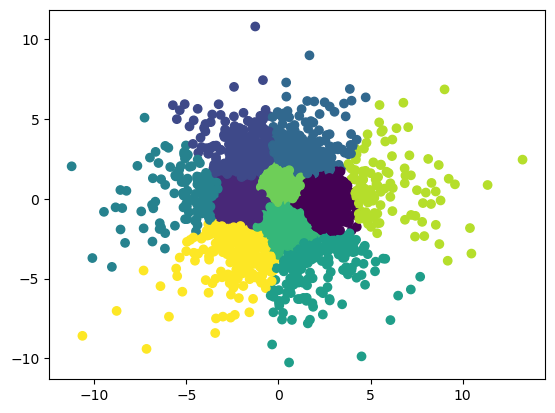

In [167]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

# Obtener las palabras más comunes en cada modelo de forma individual.
ASW_common = ASW_model.wv.index_to_key
Globant_common = Globant_model.wv.index_to_key
Accenture_common = Accenture_model.wv.index_to_key

# Encontrar las palabras únicas en cada modelo que no estén presentes en los otros modelos.
ASW_unique = set(ASW_common) - set(Globant_common) - set(Accenture_common)
Globant_unique = set(Globant_common) - set(ASW_common) - set(Accenture_common)
Accenture_unique = set(Accenture_common) - set(ASW_common) - set(Globant_common)

# Calcular los vectores de palabras para cada conjunto de palabras únicas.
ASW_vectors = [ASW_model.wv.get_vector(word) for word in ASW_unique]
Globant_vectors = [Globant_model.wv.get_vector(word) for word in Globant_unique]
Accenture_vectors = [Accenture_model.wv.get_vector(word) for word in Accenture_unique]

# Combinar los vectores de palabras en una lista.
unique_word_vectors = ASW_vectors + Globant_vectors + Accenture_vectors

# Reducir la dimensionalidad de los vectores utilizando PCA.
pca = PCA(n_components=2)
unique_word_vectors_pca = pca.fit_transform(unique_word_vectors)

# Aplicar k-means para encontrar clusters.
kmeans = KMeans(n_clusters=10, random_state=0)
kmeans.fit(unique_word_vectors_pca)

# graficar los resultados de k-means
plt.scatter(unique_word_vectors_pca[:, 0], unique_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Asignar etiquetas a cada palabra única según el cluster correspondiente.
labels = defaultdict(str)
for i, word in enumerate(ASW_unique):
    labels[word] = "ASW"
for i, word in enumerate(Globant_unique):
    labels[word] = "Globant"
for i, word in enumerate(Accenture_unique):
    labels[word] = "Accenture"



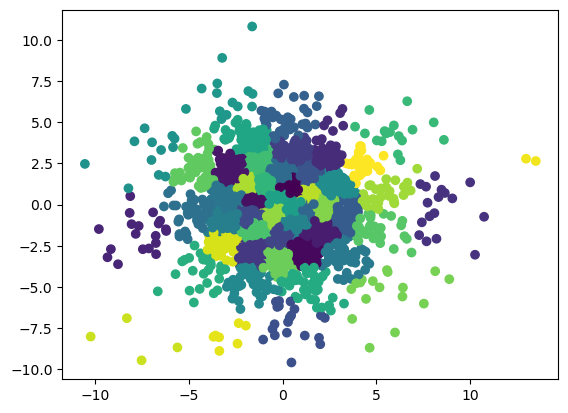

technologystay: ASW
alyson: Accenture
puppy: ASW
pays: Accenture
summer: Accenture
greater: Accenture
5_key: Accenture
castillo: ASW
75: Accenture
🍓: Accenture
unequivocally: Accenture
coral: Accenture
offside: ASW
cnn: ASW
experiencesdiscover: Globant
tudo: Globant
zahara: Accenture
get_know: Globant
technologyenabled: Accenture
man_behind: ASW
or: Accenture
monica: Globant
marc: Accenture
by: Accenture
kcl: ASW
skilled: Accenture
etailer: Accenture
groups: Accenture
buildersapply: Globant
100yearold: Globant
alliance: Globant
steinacker: Accenture
charlie: ASW
casual: Globant
therapeuticsdiscover: Globant
mortgage: Accenture
sectornominate: Globant
gómez: ASW
digitalization: Globant
studiosthis: Globant
abstract: ASW
privado: Globant
conhecer: Globant
screen: Accenture
miamidade: Globant
sopa: ASW
subscribe: Globant
leather: Accenture
tutorial: Globant
finalist: Globant
bet: ASW
mentorship: Globant
500000: Accenture
rasmus: Accenture
dublin: Accenture
pessoas: Globant
🟢: Globant
gen:

In [168]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from collections import defaultdict

# Get the unique words for each model
ASW_unique = set(ASW_model.wv.index_to_key) - set(Globant_model.wv.index_to_key) - set(Accenture_model.wv.index_to_key)
Globant_unique = set(Globant_model.wv.index_to_key) - set(ASW_model.wv.index_to_key) - set(Accenture_model.wv.index_to_key)
Accenture_unique = set(Accenture_model.wv.index_to_key) - set(ASW_model.wv.index_to_key) - set(Globant_model.wv.index_to_key)

# Get the word vectors for the unique words across each model
unique_word_vectors = []
for word in ASW_unique:
    unique_word_vectors.append(ASW_model.wv.get_vector(word))
for word in Globant_unique:
    unique_word_vectors.append(Globant_model.wv.get_vector(word))
for word in Accenture_unique:
    unique_word_vectors.append(Accenture_model.wv.get_vector(word))

# Reduce the dimensionality of the vectors using PCA
pca = PCA(n_components=2)
unique_word_vectors_pca = pca.fit_transform(unique_word_vectors)

# Apply k-means
kmeans = KMeans(n_clusters=50, random_state=0)
kmeans.fit(unique_word_vectors_pca)

# Plot the results of k-means
plt.scatter(unique_word_vectors_pca[:, 0], unique_word_vectors_pca[:, 1], c=kmeans.labels_)
plt.show()

# Assign labels to each unique word according to the corresponding cluster.
labels = defaultdict(str)
for i, word in enumerate(ASW_unique):
    labels[word] = "ASW"
for i, word in enumerate(Globant_unique):
    labels[word] = "Globant"
for i, word in enumerate(Accenture_unique):
    labels[word] = "Accenture"

# Print the unique words and their corresponding company.
for i, word in enumerate(ASW_unique | Globant_unique | Accenture_unique):
    print(f"{word}: {labels[word]}")

# Print the most common clusters for each company
for company, unique_words in [("ASW", ASW_unique), ("Globant", Globant_unique), ("Accenture", Accenture_unique)]:
    company_word_vectors = []
    for word in unique_words:
        company_word_vectors.append(ASW_model.wv.get_vector(word) if company == "ASW" else
                                     Globant_model.wv.get_vector(word) if company == "Globant" else
                                     Accenture_model.wv.get_vector(word))
    
    company_word_vectors_pca = pca.transform(company_word_vectors)
    kmeans_labels = kmeans.predict(company_word_vectors_pca)
    company_cluster_counts = defaultdict(int)
    for i in range(len(unique_words)):
        company_cluster_counts[kmeans_labels[i]] += 1
    company_words_in_clusters = defaultdict(list)
    for i, word in enumerate(unique_words):
        company_words_in_clusters[kmeans_labels[i]].append(word)
    company_most_common_clusters = sorted(company_words_in_clusters.items(), key=lambda x: len(x[1]), reverse=True)
    
    print(f"Most common clusters for {company}:")
    for cluster, words in company_most_common_clusters:
        print(f"Cluster {cluster}: {words}")
